Kaggle Bike Sharing - challenge

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

files:
train.csv
test.csv
sampleSubmission.csv

Data description:

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields:
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals

In [18]:
#importing libraries
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


In [4]:
#importing the dataset
dailyData = pd.read_csv(r'C:\Users\itskh\Documents\FALL 2023 Classes\DATA 3402\train.csv')



In [5]:
#shape of data
dailyData.shape

(10886, 12)

In [6]:
#read first few rows of the dataset
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [7]:
#look at the types of variables
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [8]:
#feature engineering
#change columns for season, holiday, workingday, and weather to categorical data type from int

#creating new columns for datetime column
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [9]:
#converting the data type from int to categorical
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [10]:
#dropping unnecessary columns
dailyData  = dailyData.drop(["datetime"],axis=1)

[Text(0.5, 0, 'variableTypeariable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables DataType Count')]

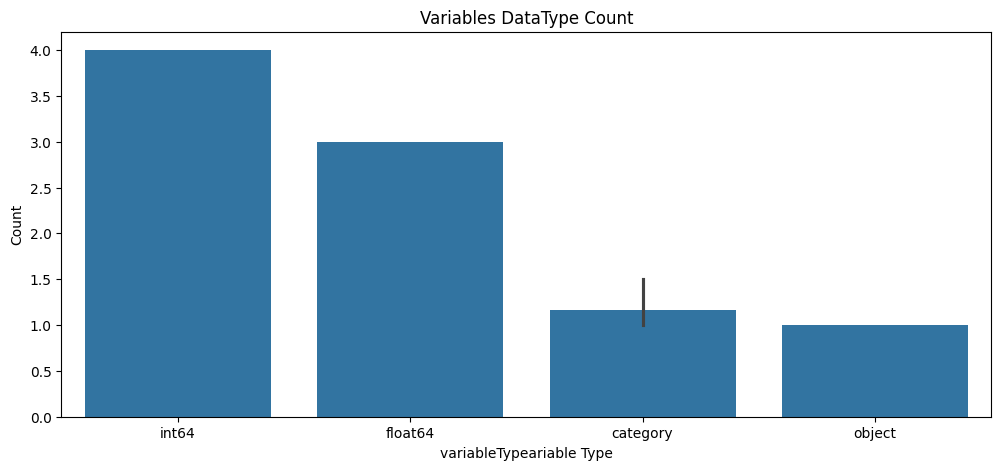

In [11]:
#visualization for the variables datatype count
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

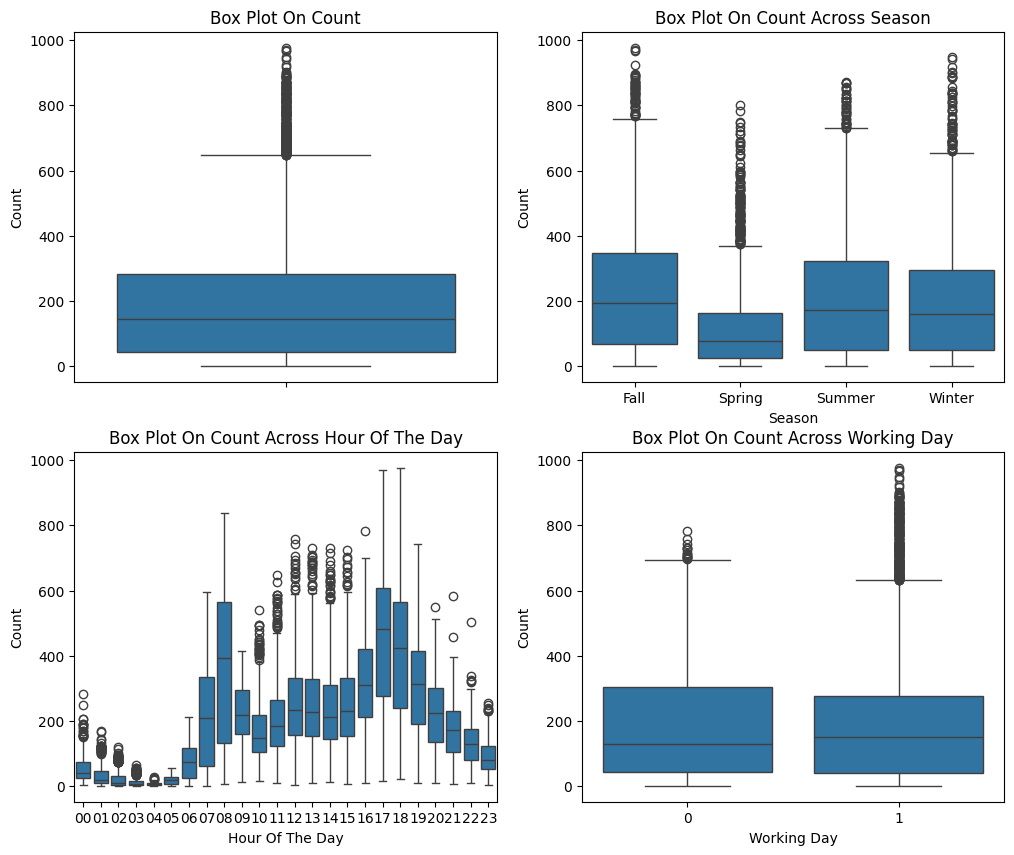

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

1)Spring Season and Lower Count:
Spring season has a relatively lower count.
The dip in the median value in the box plot provides evidence for this observation.

2)Hour of the Day Boxplot:
The boxplot analysis of the "Hour of the Day" is interesting.
Higher median values are observed at 7 AM - 8 AM and 5 PM - 6 PM.
You attribute these peaks to regular school and office users during these times.

3)Outliers and Working Days:
Most of the outlier points are contributed by "Working Day" rather than "Non-Working Day."
This is visibly evident from Figure 4.

In [13]:
#removing outliers
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [14]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


<Axes: >

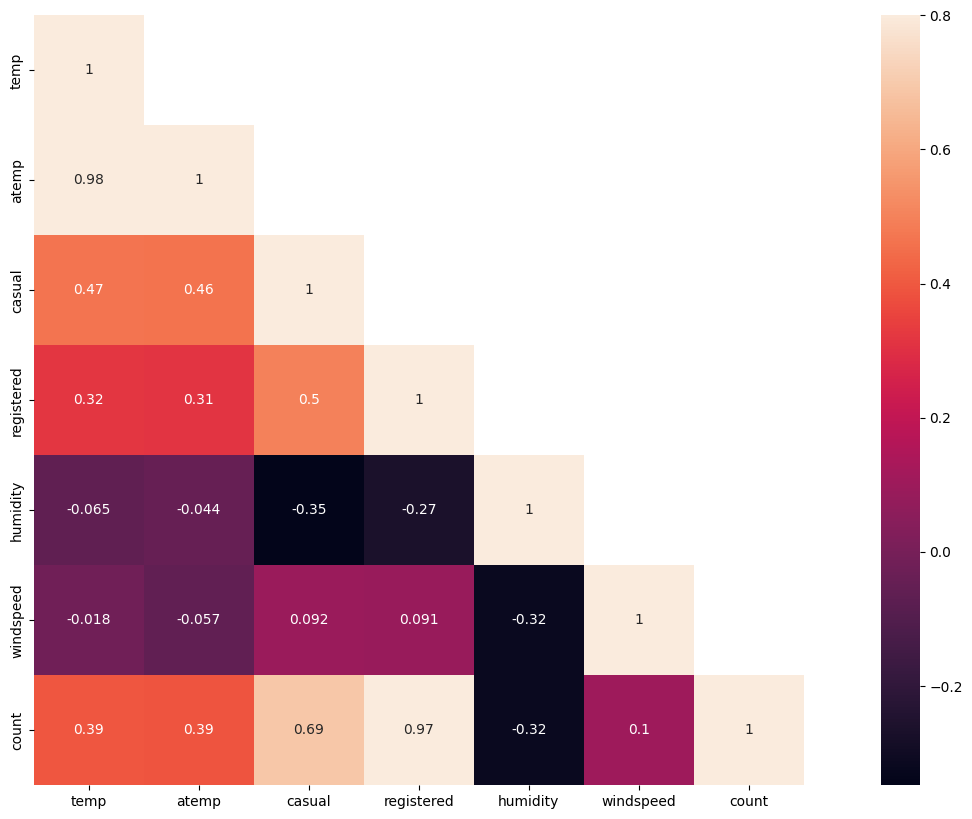

In [15]:
#correlation analysis
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

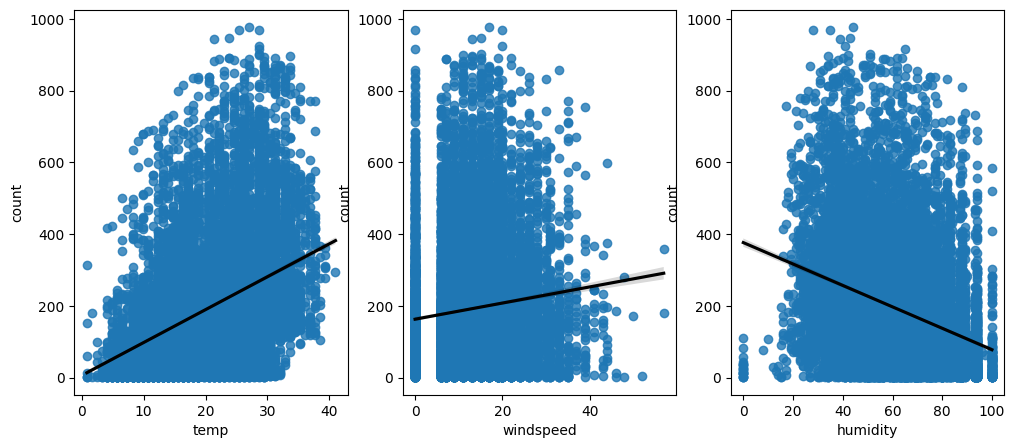

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)

# Set color to black for the regression line only
line_kws = {'color': 'black'}

sns.regplot(x="temp", y="count", data=dailyData, ax=ax1, line_kws=line_kws)
sns.regplot(x="windspeed", y="count", data=dailyData, ax=ax2, line_kws=line_kws)
sns.regplot(x="humidity", y="count", data=dailyData, ax=ax3, line_kws=line_kws)

plt.show()

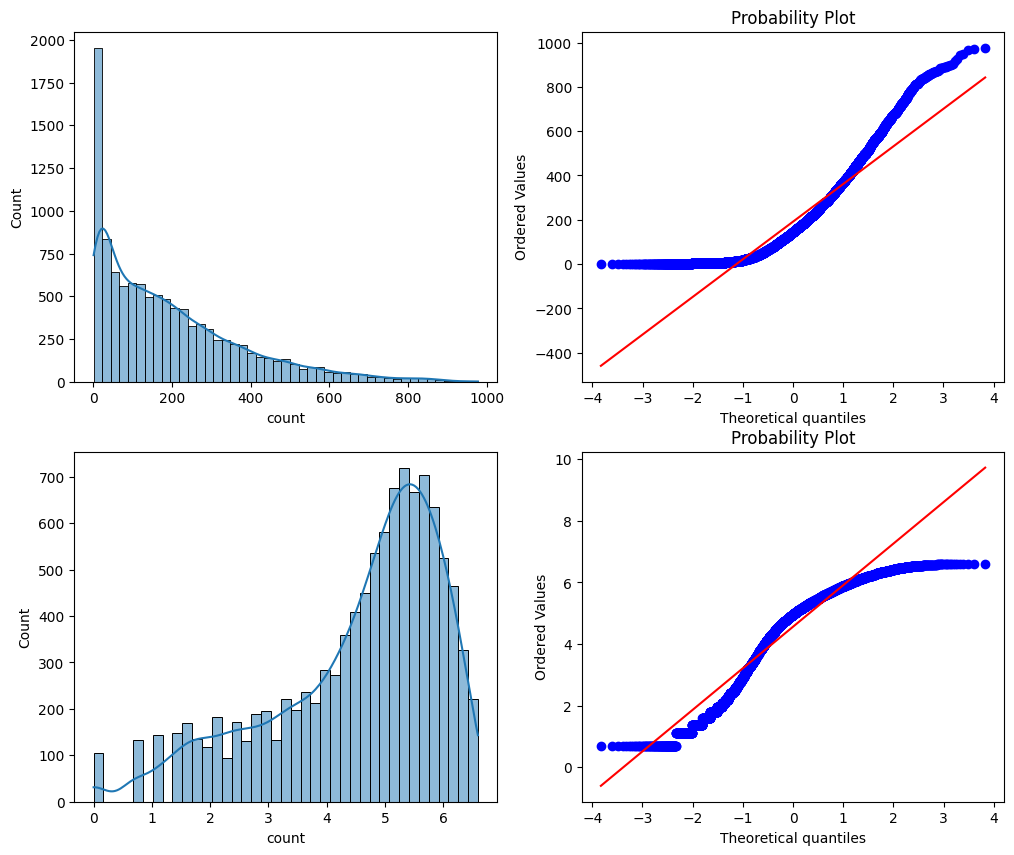

In [24]:
#distribution of the data
# subplots
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(12, 10)

#plot original distribution
sns.histplot(dailyData["count"], kde=True, ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])

# plot log-transformed distribution
sns.histplot(np.log(dailyDataWithoutOutliers["count"]), kde=True, ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

#show the plots
plt.show()

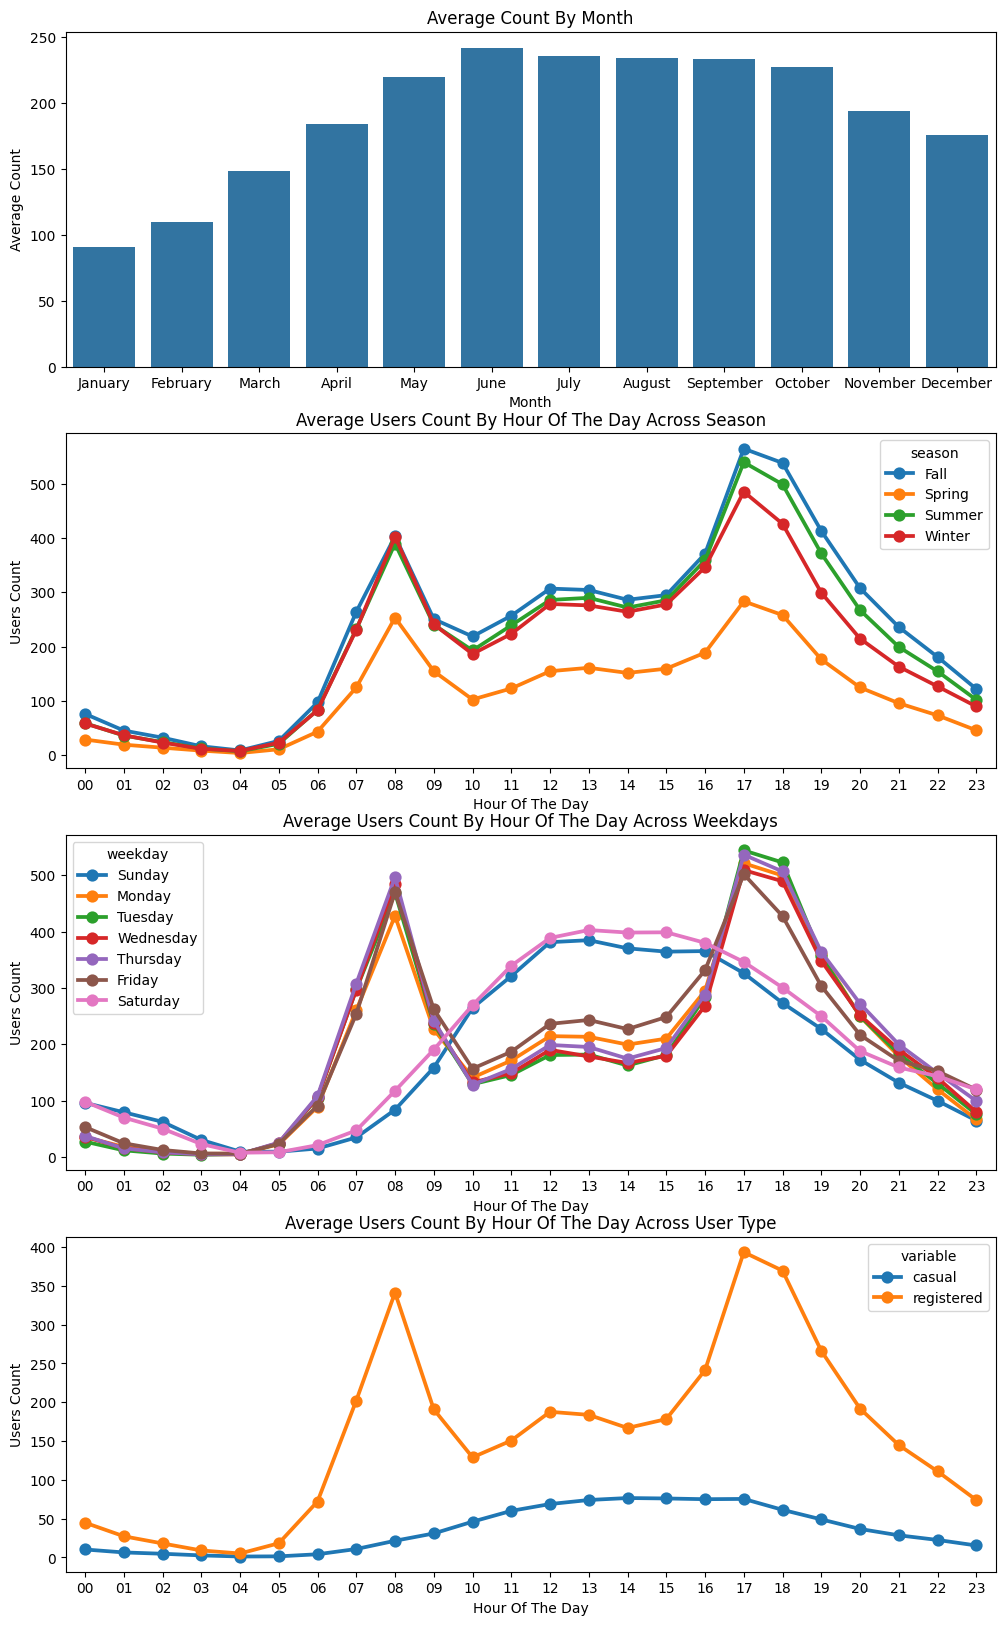

In [27]:
# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig.set_size_inches(12, 20)

sortOrder = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
hueOrder = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Plot 1: Average Count By Month
monthAggregated = dailyData.groupby("month", observed=False)["count"].mean().reindex(sortOrder)
sns.barplot(x=monthAggregated.index, y=monthAggregated.values, ax=ax1)
ax1.set(xlabel='Month', ylabel='Average Count', title="Average Count By Month")

# Plot 2: Average Users Count By Hour Of The Day Across Season
hourAggregatedSeason = dailyData.groupby(["hour", "season"], sort=True, observed=False)["count"].mean().reset_index()
sns.pointplot(x=hourAggregatedSeason["hour"], y=hourAggregatedSeason["count"], hue=hourAggregatedSeason["season"], data=hourAggregatedSeason, ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Season")

# Plot 3: Average Users Count By Hour Of The Day Across Weekdays
hourAggregatedWeekday = dailyData.groupby(["hour", "weekday"], sort=True, observed=False)["count"].mean().reset_index()
sns.pointplot(x=hourAggregatedWeekday["hour"], y=hourAggregatedWeekday["count"], hue=hourAggregatedWeekday["weekday"], hue_order=hueOrder, data=hourAggregatedWeekday, ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Weekdays")

# Plot 4: Average Users Count By Hour Of The Day Across User Type
hourTransformed = pd.melt(dailyData[["hour", "casual", "registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregatedUserType = hourTransformed.groupby(["hour", "variable"], sort=True, observed=False)["value"].mean().reset_index()
sns.pointplot(x=hourAggregatedUserType["hour"], y=hourAggregatedUserType["value"], hue=hourAggregatedUserType["variable"], hue_order=["casual", "registered"], data=hourAggregatedUserType, ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across User Type")

# Show the plots
plt.show()

In [40]:
#read in train and test
dataTrain = pd.read_csv(r"C:\Users\itskh\Documents\FALL 2023 Classes\DATA 3402\train.csv")
dataTest = pd.read_csv(r"C:\Users\itskh\Documents\FALL 2023 Classes\DATA 3402\test.csv")


In [41]:
#combine test and train
data = pd.concat([dataTrain, dataTest], ignore_index=True)

In [42]:
#feature engineering
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

In [43]:
#Random Forest Model To Predict 0's In Windspeed

from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
dataWind0Values = rfModel_wind.predict(dataWind0[windColumns])
data.loc[data["windspeed"] == 0, "windspeed"] = dataWind0Values


In [44]:
#changing to categorical type
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [45]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [46]:
#Splitting train and test data
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

In [47]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

In [48]:
#Dropping unnecessary variables
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [49]:
#RMSLE scorer and linear regression model
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
# convert all features to numeric types
for col in dataTrain.columns:
    dataTrain[col] = pd.to_numeric(dataTrain[col], errors='coerce')

# drop any rows with missing values
dataTrain = dataTrain.dropna()

# initialize logistic regression model
lModel = LinearRegression()

# train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X=dataTrain, y=yLabelsLog)

# predictions
preds = lModel.predict(X=dataTrain)
print("RMSLE Value For Linear Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))


RMSLE Value For Linear Regression:  0.9779630256572818


{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.977963010591225


<Axes: xlabel='alpha', ylabel='rmsle'>

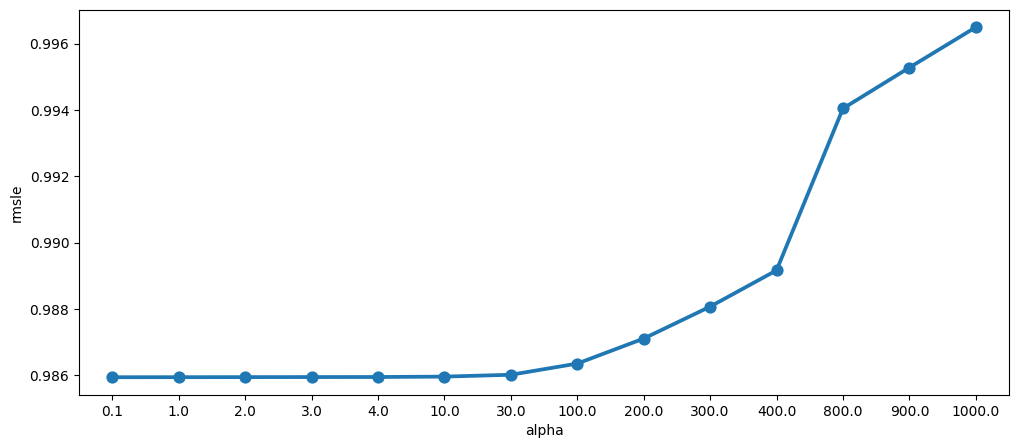

In [50]:
#regularization model - ridge
ridge_m_ = Ridge()
ridge_params_ = {'max_iter': [3000], 'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                            ridge_params_,
                            scoring=rmsle_scorer,
                            cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit(dataTrain, yLabelsLog)
preds = grid_ridge_m.predict(X=dataTrain)
print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x: x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x: -x)
sn.pointplot(data=df, x="alpha", y="rmsle", ax=ax)


{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9781001063703005


<Axes: xlabel='alpha', ylabel='rmsle'>

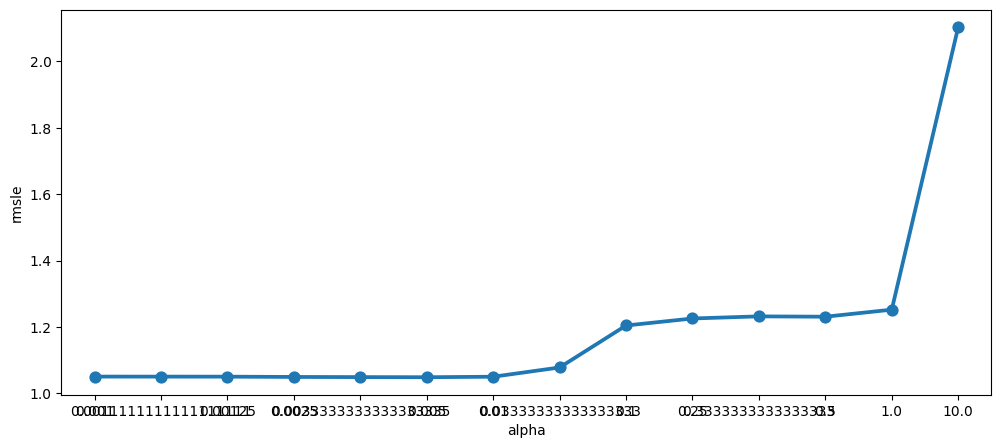

In [53]:
#Regularization Model - Lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_m_ = Lasso()

alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = {'max_iter': [3000], 'alpha': alpha}

grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring='neg_mean_squared_error', cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(dataTrain, yLabelsLog)
preds = grid_lasso_m.predict(X=dataTrain)
print(grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x: x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x: -x)
sns.pointplot(data=df, x="alpha", y="rmsle", ax=ax)

In [63]:
#Ensemble Models - Random Forest
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10300092634661223


In [62]:
#Ensemble Model - Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

Shape of dataTrain: (10886, 12)
Shape of yLabelsLog: (10886,)
RMSLE Value For Gradient Boost: 0.1883498851171197


C:\Users\itskh\AppData\Local\Temp\ipykernel_19380\1303283762.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(yLabels,ax=ax1,bins=50)
C:\Users\itskh\AppData\Local\Temp\ipykernel_19380\1303283762.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn.distplot(np.exp(predsTest),ax=ax2,bins=50)


<Axes: ylabel='Density'>

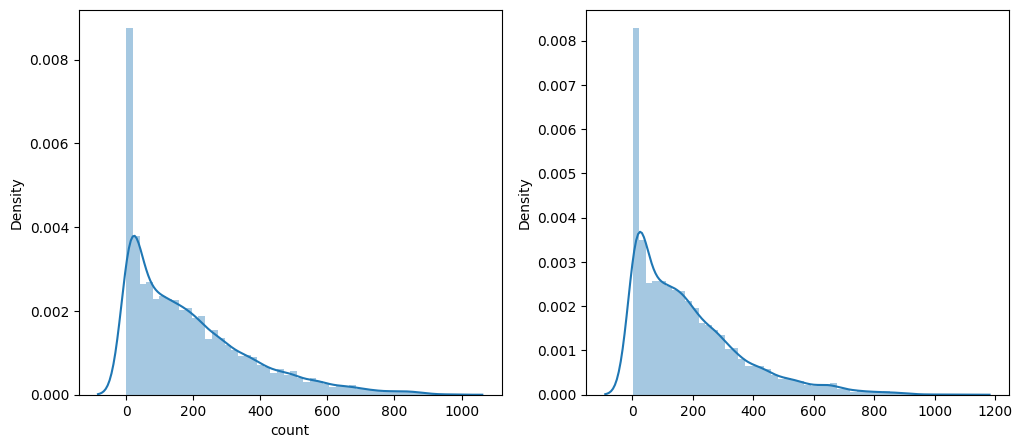

In [67]:
#compare the distribution of train and test results
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [84]:
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_sharing_demand_submission_kaggle.csv', index=False)

In [75]:
import pandas as pd

# Adjust the file path based on your directory structure
submission_data = pd.read_csv("bike_sharing_demand_submission_kaggle.csv")
num_instances_submission = submission_data.shape[0]

print("Number of instances in bike_sharing_demand_submission_kaggle.csv:", num_instances_submission)


Number of instances in bike_sharing_demand_submission_kaggle.csv: 6493
